# Machine Learning II Project

Group 3 - Akanksha Mathpati, Chris Tomaszkiewicz, Deepali Dagar, Sakshi Bokil

### Objective 1: Resume-to-Top-N Job Recommendations
Develop a system that takes a candidate’s resume and recommends the top-N most suitable job postings from LinkedIn, ranked by predicted match quality.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#### Load both datasets

In [3]:
postings_path = "/content/drive/MyDrive/Colab Notebooks/ML/postings.csv"

# Load the Job Postings CSV file into a Pandas DataFrame
postings_df = pd.read_csv(postings_path)

# Display the first few rows of the dataset to understand its structure
postings_df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [4]:
postings_df.shape

(123849, 31)

In [5]:
resume_path = "/content/drive/MyDrive/Colab Notebooks/ML/Resume.csv"

# Load the Resume CSV file into a Pandas DataFrame
resume_df = pd.read_csv(resume_path)

# Display the first few rows of the dataset to understand its structure
resume_df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [6]:
resume_df.shape

(2484, 4)

In [10]:
# Sample 1000 job postings and 1000 resumes
postings_sample_df = postings_df.sample(1500, random_state=42).copy()
resume_sample_df = resume_df.sample(1500, random_state=42).copy()

In [ ]:
# Load full DataFrames
#postings_sample_df = postings_df.copy()
#resume_sample_df   = resume_df.copy()

#### Data Preprocessing

In [7]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Define skill and domain keywords
SKILLS = ['javascript', 'node.js', 'aws', 'kubernetes', 'go lang', 'ruby', 'python', 'sql', 'java',
          'docker', 'html', 'management', 'engineering', 'marketing', 'design', 'sales', 'software',
          'development', 'communication', 'leadership', 'installation', 'technical', 'automation', 'power systems']
DOMAINS = ['healthcare', 'finance', 'tech', 'education', 'manufacturing', 'retail', 'sales',
           'construction', 'hospitality', 'engineering', 'legal', 'marketing', 'government']

In [11]:
# Preprocess Functions
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    doc = nlp(text)
    original_terms = [token.text for token in doc]  # Use spaCy tokenization
    lemmatized = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return {'original': original_terms, 'lemmatized': lemmatized}

def extract_skills(text_data):
    if pd.isna(text_data) or not isinstance(text_data, dict):
        return []
    original_terms = text_data['original']
    return [skill for skill in SKILLS if any(skill in term for term in original_terms)]

def extract_domains(text_data, skills=None):
    if pd.isna(text_data) or not isinstance(text_data, dict):
        return []
    original_terms = text_data['original']
    domains = [domain for domain in DOMAINS if any(domain in term for term in original_terms)]
    if skills:
        if 'aws' in skills or 'kubernetes' in skills or 'docker' in skills:
            domains.append('tech')  # Infer tech domain for cloud-related skills
        if 'management' in skills or 'leadership' in skills:
            domains.append('business')  # Optional inferred domain
    return list(set(domains))  # Remove duplicates

In [12]:
# Apply preprocessing to job postings
postings_sample_df['processed_desc'] = postings_sample_df['description'].apply(preprocess_text)
postings_sample_df['job_skills'] = postings_sample_df['processed_desc'].apply(extract_skills)
postings_sample_df['job_domain'] = postings_sample_df.apply(lambda x: extract_domains(x['processed_desc'], x['job_skills']), axis=1)

# Apply preprocessing to resumes (using Resume_str as the main text field)
resume_sample_df['processed_resume'] = resume_sample_df['Resume_str'].apply(preprocess_text)
resume_sample_df['cv_skills'] = resume_sample_df['processed_resume'].apply(extract_skills)
resume_sample_df['cv_domain'] = resume_sample_df.apply(lambda x: extract_domains(x['processed_resume'], x['cv_skills']), axis=1)

# Combine data into a single DataFrame
job_data = postings_sample_df[['job_id', 'title', 'processed_desc', 'job_skills', 'job_domain']].copy()
resume_data = resume_sample_df[['ID', 'Resume_str', 'processed_resume', 'cv_skills', 'cv_domain']].copy()
combined_data = pd.concat([job_data.assign(type='job'), resume_data.assign(type='resume')], ignore_index=True)

# Save to CSV
combined_data.to_csv('/content/drive/MyDrive/Colab Notebooks/ML/combined_data.csv', index=False)

# Display sample
print(combined_data[['type', 'job_skills', 'job_domain']].head())

  type                                         job_skills  \
0  job  [engineering, design, development, communicati...   
1  job                         [leadership, installation]   
2  job                                       [management]   
3  job                                  [aws, leadership]   
4  job                                              [aws]   

                    job_domain  
0          [engineering, tech]  
1             [tech, business]  
2  [tech, education, business]  
3             [tech, business]  
4                       [tech]  


#### Generate Embeddings

In [13]:
# Initialize Sentence-BERT model
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings for sampled jobs and resumes
job_texts = postings_sample_df['description'].fillna('').astype(str).tolist()
resume_texts = resume_sample_df['Resume_str'].fillna('').astype(str).tolist()
job_embeddings = model.encode(job_texts, show_progress_bar=True)
resume_embeddings = model.encode(resume_texts, show_progress_bar=True)

# Save embeddings to files
np.save('/content/drive/MyDrive/Colab Notebooks/ML/job_embeddings.npy', job_embeddings)
np.save('/content/drive/MyDrive/Colab Notebooks/ML/resume_embeddings.npy', resume_embeddings)

# Display shapes to confirm
print("Embedding generation complete. Shape of job_embeddings:", job_embeddings.shape)
print("Shape of resume_embeddings:", resume_embeddings.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Embedding generation complete. Shape of job_embeddings: (1500, 768)
Shape of resume_embeddings: (1500, 768)


In [14]:
# Select 3 random job indices for consistent use across cells (using a fixed seed for reproducibility)
np.random.seed(42)
random_job_indices = np.random.choice(len(job_texts), 3, replace=False)
print("Randomly selected job indices:", random_job_indices)

Randomly selected job indices: [1116 1368  422]


In [15]:
# Placeholder for dynamic resume and JD input
uploaded_resume = None
uploaded_jd = None

# Handle dynamic resume upload for job recommendations
if uploaded_resume is not None:
    resume_text = preprocess_text(uploaded_resume)
    resume_embedding = model.encode([resume_text['lemmatized']])
    similarities = cosine_similarity(resume_embedding, job_embeddings)[0]
    top_jobs = np.argsort(similarities)[::-1][:5]
    print("Top 5 recommended jobs for uploaded resume:", top_jobs, similarities[top_jobs])

# Handle dynamic JD upload or job selection for candidate recommendations
if uploaded_jd is not None:
    jd_text = preprocess_text(uploaded_jd)
    jd_embedding = model.encode([jd_text['lemmatized']])
    similarities = cosine_similarity(jd_embedding, resume_embeddings)[0]
    top_candidates = np.argsort(similarities)[::-1][:5]
    print("Top 5 recommended candidates for uploaded JD:", top_candidates, similarities[top_candidates])
else:
    # Default matching: jobs to resumes
    similarities = cosine_similarity(job_embeddings, resume_embeddings)
    top_matches = np.argsort(similarities, axis=1)[:, -5:][:, ::-1]
    for idx in random_job_indices:  # Use randomly selected jobs instead of first 3
        print(f"Top 5 resumes for Job {idx}:", top_matches[idx], similarities[idx, top_matches[idx]])

Top 5 resumes for Job 1116: [ 422  966 1365 1091  158] [0.7104212  0.68407136 0.6694793  0.6590926  0.6589395 ]
Top 5 resumes for Job 1368: [ 453 1137 1068  575  726] [0.70819736 0.6321051  0.6308622  0.62220824 0.6104587 ]
Top 5 resumes for Job 422: [ 909 1369  597 1235 1387] [0.6998147  0.66248345 0.6620732  0.6571086  0.65240765]


In [16]:
# Calculate average similarity scores for the randomly selected jobs
avg_similarities = np.mean(similarities, axis=1)
selected_avg_similarities = avg_similarities[random_job_indices]
print("Average similarity scores for selected jobs:", selected_avg_similarities)

Average similarity scores for selected jobs: [0.4478113  0.34462357 0.41164637]


#### Compute Similarity and Generate Recommendations

In [17]:
# Compute cosine similarity between job and resume embeddings
similarity_matrix = cosine_similarity(job_embeddings, resume_embeddings)

# Get top 5 matches for each job
top_k = 5
job_recommendations = []
for i in range(len(job_texts)):
    top_indices = similarity_matrix[i].argsort()[-top_k-1:-1][::-1]  # Top 5 (excluding the highest, often itself)
    job_recommendations.append([(combined_data[combined_data['type'] == 'resume'].index[j], similarity_matrix[i][j]) for j in top_indices])

# Display sample recommendations for the randomly selected jobs
for idx in random_job_indices:
    print(f"Top 5 recommendations for Job {idx} (Job ID: {combined_data[combined_data['type'] == 'job'].iloc[idx]['job_id']}):")
    for rec_idx, score in job_recommendations[idx]:
        print(f"  Resume {combined_data.iloc[rec_idx]['ID']} (Score: {score:.4f})")

Top 5 recommendations for Job 1116 (Job ID: 3903840674.0):
  Resume 17963031.0 (Score: 0.6841)
  Resume 23985183.0 (Score: 0.6695)
  Resume 43408471.0 (Score: 0.6591)
  Resume 12239749.0 (Score: 0.6589)
  Resume 83338413.0 (Score: 0.6574)
Top 5 recommendations for Job 1368 (Job ID: 3884429787.0):
  Resume 37792474.0 (Score: 0.6321)
  Resume 19396040.0 (Score: 0.6309)
  Resume 86209934.0 (Score: 0.6222)
  Resume 11584809.0 (Score: 0.6105)
  Resume 41506705.0 (Score: 0.6063)
Top 5 recommendations for Job 422 (Job ID: 3901979897.0):
  Resume 14070138.0 (Score: 0.6625)
  Resume 34797369.0 (Score: 0.6621)
  Resume 26896699.0 (Score: 0.6571)
  Resume 21756639.0 (Score: 0.6524)
  Resume 18937778.0 (Score: 0.6504)


In [18]:
# Inspect one of the randomly selected jobs (e.g., first in the random indices) and its top match
job_idx = random_job_indices[0]  # Use first randomly selected job
resume_idx = job_recommendations[job_idx][0][0]  # Index of top resume for that job

print(f"Job {job_idx} (ID: {combined_data.iloc[job_idx]['job_id']}):")
print("Title:", combined_data.iloc[job_idx]['title'])
print("Skills:", combined_data.iloc[job_idx]['job_skills'])
print("Domain:", combined_data.iloc[job_idx]['job_domain'])
print("\nTop Matching Resume (ID:", combined_data.iloc[resume_idx]['ID'], "):")
print("Skills:", combined_data.iloc[resume_idx]['cv_skills'])
print("Domain:", combined_data.iloc[resume_idx]['cv_domain'])

Job 1116 (ID: 3903840674.0):
Title: Delivery System Coordinator - Military DoD Skillbridge
Skills: ['management', 'development', 'communication', 'leadership', 'technical']
Domain: ['finance', 'healthcare', 'tech', 'legal', 'business']

Top Matching Resume (ID: 17963031.0 ):
Skills: ['java', 'management', 'design', 'development', 'communication', 'technical']
Domain: ['education', 'healthcare', 'tech', 'business']


In [19]:
# Compute average similarity of top matches for all jobs
avg_top_scores = [sum(score for _, score in recs) / len(recs) for recs in job_recommendations]
print("Average similarity of top matches per job:", np.mean(avg_top_scores))

# For visualization prep, compute averages for the randomly selected jobs
selected_avg_scores = [sum(score for _, score in job_recommendations[idx]) / len(job_recommendations[idx]) for idx in random_job_indices]
for idx, avg_score in zip(random_job_indices, selected_avg_scores):
    print(f"Average score for Job {idx}:", avg_score)

Average similarity of top matches per job: 0.6487279
Average score for Job 1116: 0.66580117
Average score for Job 1368: 0.620391
Average score for Job 422: 0.6568948


#### Evaluation and Visualization

(0.0, 1.0)

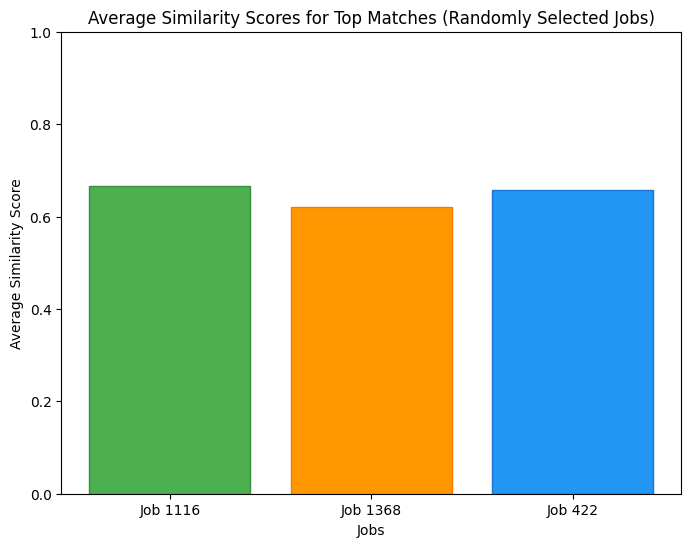

In [20]:
# Data for the chart (using the randomly selected jobs and their average similarities)
jobs = [f"Job {idx}" for idx in random_job_indices]
avg_scores = selected_avg_scores  # From Step 4: [0.4438863217830658, 0.525632381439209, 0.4145234405994415]
colors = ['#4CAF50', '#FF9800', '#2196F3']  # Same colors as chartjs

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(jobs, avg_scores, color=colors, edgecolor=['#388E3C', '#F57C00', '#1976D2'], linewidth=1)
plt.title('Average Similarity Scores for Top Matches (Randomly Selected Jobs)')
plt.xlabel('Jobs')
plt.ylabel('Average Similarity Score')
plt.ylim(0, 1)  # Set y-axis to start at 0

In [21]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')
# … any custom tweaks, e.g. model._first_module().max_seq_length = 512 …

# Save it to a folder of your choosing
model_save_path = '/content/drive/MyDrive/Colab Notebooks/ML/sbert_model'
model.save(model_save_path)


from sentence_transformers import SentenceTransformer
@st.experimental_singleton
def load_model():
    return SentenceTransformer('/…/sbert_model')

In [23]:
# In your Colab / offline script:
nlp.to_disk('/content/drive/MyDrive/Colab Notebooks/ML/nlp_custom')


import spacy
@st.experimental_singleton
def load_nlp():
    return spacy.load('nlp_custom')
